# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import optax as ox
import numpy as np
from typing import Callable, List, Tuple

In [4]:
import gymnasium as gym

In [5]:
from jax_mc_pilco.controllers import Controller, RandomController, SumOfGaussians
from jax_mc_pilco.rewards import pendulum_cost#, cart_pole_cost
from jax_mc_pilco.model_learning.gp_models import IMGPR
from jax_mc_pilco.policy_learning.rollout import fit_controller
from jax_mc_pilco.simulators.simulation import remake_state, sample_from_environment

In [6]:
import optax as ox

In [7]:
from IPython import display

## Globals

In [8]:
num_particles = 400
num_trials = 8
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01
control_horizon = int(T_control / T_sampling)
num_basis = 200
umax = 2.0

num_controllers_in_ensemble = 8

## Generate the environments

In [9]:
env = gym.make("Pendulum-v1")

In [10]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
# state is cos_theta, sin_theta, theta_dot

In [11]:
timesteps = np.linspace(0, T_exploration, int(T_exploration / sim_timestep) + 1)

## Initialize the Controllers

In [12]:
key = jr.key(42)

In [13]:
random_policy = RandomController(state_dim, action_dim, to_squash=True, max_action=umax)

# Main Loop

In [14]:
states = []
actions = []
epsilon = 1e-4
for trial in range(10):
    optimizer = ox.inject_hyperparams(ox.adam)(learning_rate=1e-2)
    if trial == 0:
        exploration_policy = random_policy
        num_opt_steps = 2000
    else:
        exploration_policy = control_policy
        num_opt_steps = 4000

    key, subkey = jr.split(key) 
    these_states, these_actions = sample_from_environment(env, timesteps, num_trials, exploration_policy, subkey)
    states.extend(these_states)
    actions.extend(these_actions)
    
    model = IMGPR(states=jnp.array(states),actions=jnp.array(actions))
    model.optimize()
    
    factor = min(1.,max(0.,(trial-5)/20.))
    if factor == 0.:
        init_state = [1e-2,1e-2] # Cannot use zero because of the reset
    else:
        key, subkey = jr.split(key)
        init_state = [float(factor*jnp.pi*jr.uniform(subkey))]
        key, subkey = jr.split(key)
        init_state.extend([float(factor*epsilon*jr.uniform(subkey))])
    break
    # key, subkey = jr.split(key)
    # control_policy, losses = fit_controller(
    #     policy=control_policy,
    #     num_particles=num_particles,
    #     initial_sample=init_state,
    #     timesteps=jnp.arange(control_horizon),
    #     gp_model=model,
    #     obj_func=pendulum_cost,
    #     optim=optimizer,
    #     num_iters=num_opt_steps,
    #     key=subkey,
    # )
    # plt.plot(losses)
    # plt.title(trial)
    # plt.show()

In [15]:
# Create an ensemble of controllers
@eqx.filter_vmap
def make_ensemble(key):
    return SumOfGaussians(
        state_dim,
        action_dim,
        num_basis,
        initial_log_lengthscales=None,
        initial_centers=None,
        to_squash=True,
        max_action=umax,
        key=key
    )
def make_initial_samples(init_state: List, num_samples: Int, env: gym.wrappers.common.TimeLimit,)->Array:
    init_samples = []
    for i in range(num_samples):
        sample, _ = env.reset(
            options={"x_init": init_state[0], "y_init": init_state[1]}
        )
        init_samples.append(sample)
    return jnp.array(init_samples)


In [16]:
num_init_conditions = 100

In [17]:
init_state = [1e-2,1e-2]
init_samples = make_initial_samples(init_state,num_init_conditions,env)

In [18]:
keys = jax.random.split(key, num_init_conditions)
control_policies = make_ensemble(keys)

In [19]:
policies = control_policies
initial_samples = init_samples
num_iters: Int = 100
unroll: Int = 5

timesteps=jnp.arange(control_horizon)
gp_model=model
obj_func=pendulum_cost
optim=optimizer
num_iters=num_opt_steps

In [30]:
# key, subkey = jr.split(key)
# control_policies, losses = fit_controller(
#     policies = control_policies,
#     initial_samples = init_samples,
#     num_particles=num_particles,
#     timesteps=jnp.arange(control_horizon),
#     gp_model=model,
#     obj_func=pendulum_cost,
#     optim=optimizer,
#     num_iters=num_opt_steps,
#     key=subkey,
# )

In [21]:
init_samples[:,jnp.newaxis,:].shape

(100, 1, 3)

In [22]:
@eqx.filter_vmap
def evaluate_per_ensemble(model, x, t):
    return eqx.filter_vmap(model)(x, t)

@eqx.filter_vmap
def init_evaluate_per_ensemble(model, x, t):
    return model(x, t)

# Now do a rollout with this model
# Generate initial actions
u = evaluate_per_ensemble(policies, init_samples[:,jnp.newaxis,:], 0.0)
# initialize some particles
key, subkey = jr.split(key)
initial_particles = gp_model.get_samples(subkey, initial_samples, u, num_particles)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [45]:
#@eqx.debug.assert_max_traces(max_traces=1)
def rollout(
    policy: eqx.Module,
    init_samples: ArrayLike,
    model: eqx.Module,
    timesteps: ArrayLike,
    key: ArrayLike = jr.key(123),
) -> Float:
    policy_params, policy_static = eqx.partition(policy, eqx.is_array)

    def one_rollout_step(
        carry: Tuple[ArrayLike, ArrayLike, ArrayLike, Float], timestep: Float
    ) -> Tuple[Tuple[ArrayLike, ArrayLike, ArrayLike, Float], Float]:
        policy_params, key, samples, total_cost = carry
        policy = eqx.combine(policy_params, policy_static)
        actions = evaluate_per_ensemble(
            policy, samples, jnp.tile(timestep, num_particles)
        )

        key, subkey = jr.split(key)
        samples = model.get_samples(key, samples, actions, 1)
        cost = jnp.mean(jax.vmap(obj_func)(jnp.hstack((samples, actions))))
        return (policy_params, key, samples, total_cost + cost), cost

    total_cost = 0
    (policy_params, key, samples, total_cost), result = jax.lax.scan(
        one_rollout_step, (policy_params, key, init_samples, total_cost), timesteps
    )
    return total_cost

In [39]:
opt_states = eqx.filter_vmap(optim.init)(eqx.filter(policies, eqx.is_array))

In [40]:
# Mini-batch random keys to scan over.
iter_keys = jr.split(key, num_iters)

# Optimisation step.
@eqx.filter_jit
@eqx.filter_vmap
def make_step(
    policy: eqx.Module,
    opt_states: PyTree,
) -> Tuple[eqx.Module, PyTree, Float]:
    loss_value, loss_gradient = eqx.filter_value_and_grad(rollout)(
        policy, initial_particles, gp_model, timesteps
    )
    updates, opt_state = optim.update(
        loss_gradient, opt_state, eqx.filter(policy, eqx.is_array)
    )
    policy = eqx.apply_updates(policy, updates)
    return policy, opt_state, loss_value

In [43]:
#policies, opt_states, train_losses = make_step(policies, opt_states)

In [51]:
policy_params, policy_static = eqx.partition(policies, eqx.is_array)

In [52]:
def one_rollout_step(
    carry: Tuple[ArrayLike, ArrayLike, ArrayLike, Float], timestep: Float
) -> Tuple[Tuple[ArrayLike, ArrayLike, ArrayLike, Float], Float]:
    policy_params, key, samples, total_cost = carry
    policy = eqx.combine(policy_params, policy_static)
    actions = evaluate_per_ensemble(
        policy, samples, jnp.tile(timestep, num_particles)
    )

    key, subkey = jr.split(key)
    samples = model.get_samples(key, samples, actions, 1)
    cost = jnp.mean(jax.vmap(obj_func)(jnp.hstack((samples, actions))))
    return (policy_params, key, samples, total_cost + cost), cost

In [68]:
key, subkey = jr.split(key)
carry = (policy_params, subkey, initial_particles, 0)

In [69]:
policy_params, key, samples, total_cost = carry

In [70]:
policy = eqx.combine(policy_params, policy_static)

In [71]:
actions = evaluate_per_ensemble(
    policy, samples, 0.0
)

In [72]:
samples = model.get_samples(key, samples, actions, 1)

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 1 for shapes (100, 400, 3), (100, 400, 1).

In [63]:
samples.shape

(100, 3)

In [22]:
key, subkey = jr.split(key)
theta = 2*init_state[0]*jr.uniform(subkey,shape=(num_init_conditions,))-init_state[0]
theta_dot = 2*init_state[1]*jr.uniform(subkey,shape=(num_init_conditions,))-init_state[1]
samples = jnp.vstack((jnp.sin(theta),jnp.cos(theta),theta_dot)).T

In [67]:
initial_particles.shape, samples.shape, actions.shape

((100, 400, 3), (100, 3), (100, 1))

In [ ]:
env_test = gym.make("Pendulum-v1", render_mode="rgb_array")

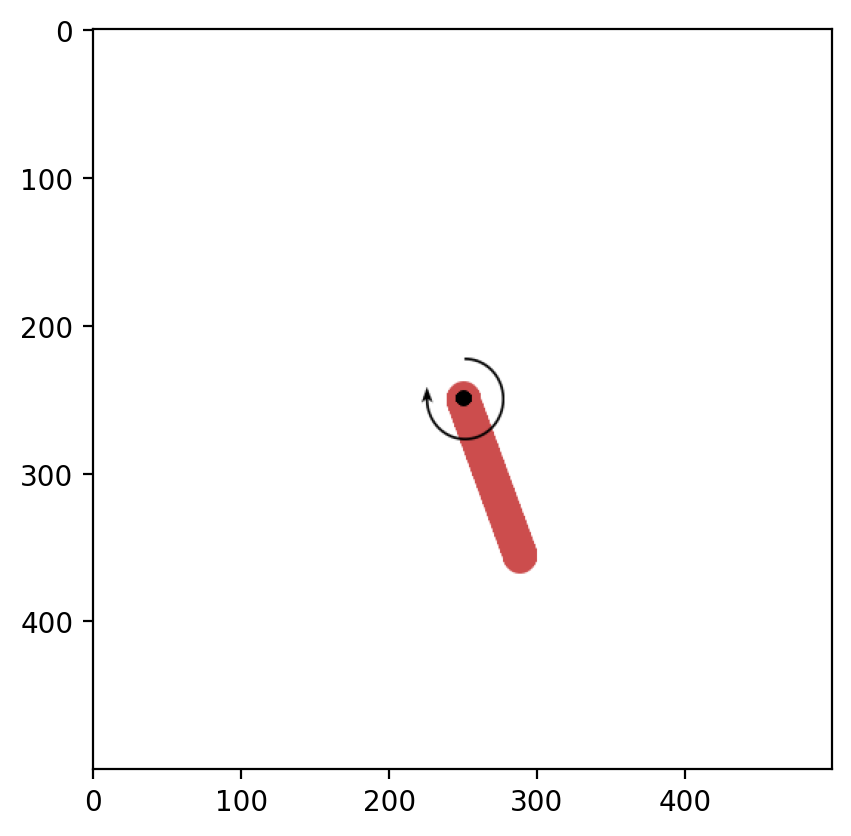

In [19]:
# Now try this policy on the real system
state, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(state,0.0)
# Randomly sample some points
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,5000*T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    state = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)